**Mounting Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


**Copying all the functions defined from the py_utils path**



In [0]:
!cp /content/gdrive/My\ Drive/Colab\ Notebooks/Facial\ Recognition/py_utils/py_utils/*.* /content

**Installing VGG Model**

In [8]:
!pip install git+https://github.com/rcmalli/keras-vggface.git --quiet

**Installing ipywidgets**

In [0]:
!pip install ipywidgets --quiet

**Importing the libraries**

In [10]:
import tensorflow
print(tensorflow.__version__)

1.15.2


In [0]:
import os, sys
import glob
import shutil
import zipfile
import numpy as np
import math
import tarfile
import re
import pickle
import requests
from tqdm import tqdm_notebook as tqdm
from numpy.random import random, permutation
from matplotlib import pyplot as plt
from PIL import Image
import time

In [0]:
from keras import backend as K
from keras.engine import  Model
from keras.layers import Flatten, Dense, Input, Lambda
from keras.utils.data_utils import get_file
from itertools import islice
from matplotlib import rcParams
import random
from PIL import ImageOps, ImageFont, ImageDraw 
import dlib
from skimage import io, transform
import tensorflow as tf
import ipywidgets as widgets
from keras_vggface.vggface import VGGFace
from keras.preprocessing import image
from keras_vggface import utils
from myutils import *

### Business Problem 
**Our client has requested to develop the Facial  Recognition software to grant access entries to the presidents part of their community. In this notebook, we have used list of 7 presidents Mr.Obama, Mr.Clinton, Mr.Bush, Mr.Carter, Mr. Reagen, Mr.Nixon and Mr.Trump**


In [0]:
pres_names = "obama, clinton, bush, carter, reagan, nixon, trump"

In [16]:
# Converting to a list
name_list = pres_names.split(','); 
pres_list = []
for name in name_list:
  pres_list.append(name.strip())

print(pres_list)

['obama', 'clinton', 'bush', 'carter', 'reagan', 'nixon', 'trump']


**Defining the downloadable, orginal paths for the images**


In [0]:
download_path = "/content/gdrive/My Drive/Colab Notebooks/Facial Recognition/pres_images/"
org_img_path = "/content/gdrive/My Drive/Colab Notebooks/Facial Recognition/original_images/"
face_img_path = "/content/gdrive/My Drive/Colab Notebooks/Facial Recognition/cropped_images/"
selected_path = "/content/gdrive/My Drive/Colab Notebooks/Facial Recognition/selected_images/"

**Downloading from Google images**

In [0]:
# !pip install google_images_download --quiet

In [0]:
# from google_images_download import google_images_download   #importing the library

# response = google_images_download.googleimagesdownload()   #class instantiation
# arguments = {"keywords":pres_names,"limit":5,"print_urls":True}   #creating list of arguments
# #arguments = {"keywords":"car plates","format":"png","limit":5,"print_urls":True}
# paths = response.download(arguments)

**Moving Images from Downloaded Path to orginal path**

In [0]:
def move_images_from_download_to_orginal(path, dest):
    
    for f in os.listdir(path):
        source_path = path+f+'/'
        if os.path.isdir(path+f):
            for r, d, fil in os.walk(path+f):
                
                dir_list = r.split("/")
                label = dir_list[-1].strip()
                name_dir = dest+label+'/'
                make_path(name_dir)
                    
                for idx in (range(0, len(fil))):
                  if fil[idx].endswith(".jpeg"):  
                    fname = label+str(idx) 
                    shutil.copyfile(source_path+fil[idx], name_dir +fname+'.jpeg')
                    print('Copied' +str(name_dir +fname+'.jpeg') )

In [47]:
move_images_from_download_to_orginal(download_path, org_img_path)

Copied/content/gdrive/My Drive/Colab Notebooks/Facial Recognition/original_images/bush/bush0.jpeg
Copied/content/gdrive/My Drive/Colab Notebooks/Facial Recognition/original_images/bush/bush1.jpeg
Copied/content/gdrive/My Drive/Colab Notebooks/Facial Recognition/original_images/bush/bush2.jpeg
Copied/content/gdrive/My Drive/Colab Notebooks/Facial Recognition/original_images/bush/bush3.jpeg
Copied/content/gdrive/My Drive/Colab Notebooks/Facial Recognition/original_images/bush/bush4.jpeg
Copied/content/gdrive/My Drive/Colab Notebooks/Facial Recognition/original_images/trump/trump0.jpeg
Copied/content/gdrive/My Drive/Colab Notebooks/Facial Recognition/original_images/trump/trump1.jpeg
Copied/content/gdrive/My Drive/Colab Notebooks/Facial Recognition/original_images/trump/trump2.jpeg
Copied/content/gdrive/My Drive/Colab Notebooks/Facial Recognition/original_images/trump/trump3.jpeg
Copied/content/gdrive/My Drive/Colab Notebooks/Facial Recognition/original_images/trump/trump4.jpeg
Copied/con

**Detecting and cropping images**

In [49]:
#Looking at the number of files in the downloaded path
files_in_path(download_path)

{'bush': 5,
 'carter': 5,
 'clinton': 5,
 'nixon': 5,
 'obama': 5,
 'reagan': 5,
 'trump': 5}

In [0]:
#Function to Detect the faces in the image

def detect_faces(image):

    # Create a face detector
    face_detector = dlib.get_frontal_face_detector()

    # Run detector and get bounding boxes of the faces on image.
    detected_faces = face_detector(image, 1)
    face_frames = [(x.left(), x.top(),
                    x.right(), x.bottom()) for x in detected_faces]

    return face_frames

In [0]:
#Creating a cropped image after the image is detected
def create_cropped_images(original_path, cropped_path):
  for f in os.listdir(original_path):
    print('\nCropping ' + str(f) + ' Images\n')
    name_cropped_dir = cropped_path+f+'/'
    make_path(name_cropped_dir)
    for r, d, fil_list in os.walk(original_path+f):
      for fname in fil_list:
        image = io.imread(original_path+f+'/'+fname)
        detected_faces = detect_faces(image)
        if (len(detected_faces)):
          face = Image.fromarray(image).crop(detected_faces[0])
          face.save(name_cropped_dir+fname)
          print('Cropped and saved to' +str(name_cropped_dir+fname))

In [57]:
create_cropped_images(download_path, face_img_path)


Cropping bush Images

Cropped and saved to/content/gdrive/My Drive/Colab Notebooks/Facial Recognition/cropped_images/bush/bush1.jpeg
Cropped and saved to/content/gdrive/My Drive/Colab Notebooks/Facial Recognition/cropped_images/bush/bush3.jpeg
Cropped and saved to/content/gdrive/My Drive/Colab Notebooks/Facial Recognition/cropped_images/bush/bush4.jpeg
Cropped and saved to/content/gdrive/My Drive/Colab Notebooks/Facial Recognition/cropped_images/bush/bush2.jpeg
Cropped and saved to/content/gdrive/My Drive/Colab Notebooks/Facial Recognition/cropped_images/bush/bush5.jpeg

Cropping trump Images

Cropped and saved to/content/gdrive/My Drive/Colab Notebooks/Facial Recognition/cropped_images/trump/trump1.jpeg
Cropped and saved to/content/gdrive/My Drive/Colab Notebooks/Facial Recognition/cropped_images/trump/trump4.jpeg
Cropped and saved to/content/gdrive/My Drive/Colab Notebooks/Facial Recognition/cropped_images/trump/trump5.jpeg
Cropped and saved to/content/gdrive/My Drive/Colab Notebook

**Once presidents are accepted by the community, we push their images into our facial recognition software database to allow in future**


In [0]:
def checkboxes (data):
  names = []
  checkbox_objects = []
  for item in data:
      checkbox_objects.append(widgets.Checkbox(value=False, description=item))
      names.append(item)

  arg_dict = {names[i]: checkbox for i, checkbox in enumerate(checkbox_objects)}

  ui = widgets.VBox(children=checkbox_objects)

  selected_data = []
  def select_data(**kwargs):
      selected_data.clear()
      for key in kwargs:
          if kwargs[key] is True:
              selected_data.append(key)
              
  out = widgets.interactive_output(select_data, arg_dict)
  return ui, selected_data

In [0]:
def show_multiple_images(path):
  fig = plt.figure(figsize=(9, 13))
  fnums = len(os.listdir(path))
  columns = 4
  rows = math.ceil(fnums/columns)
  ax = []
  for r, d, fil_list in os.walk(path):
      for i, fname in enumerate(fil_list):
        img=Image.open(path+'/'+ fname)
        ax.append( fig.add_subplot(rows, columns, i+1) )
        ax[-1].set_title(fname)  # set title
        plt.imshow(img, alpha=1)
      plt.show()
  ui, selected_data = checkboxes (fil_list)
  display(ui)
  return selected_data, r

In [0]:
def move_selected(selection, path):
  fpath = path.replace('cropped', 'selected')
  if os.path.exists(fpath):
    shutil.rmtree(fpath)
  os.makedirs(fpath)
  files = []
  for fname in selection:
    shutil.copyfile(path+'/'+fname, fpath+'/'+fname)
    files.append(fpath+'/'+fname)
  show_multiple_images(fpath)

**Selecting the presidents. In future, when these presidents enter, they will be allowed. In the beginning, I'm pushing 2 images of all the presidents into the facial recognition software**

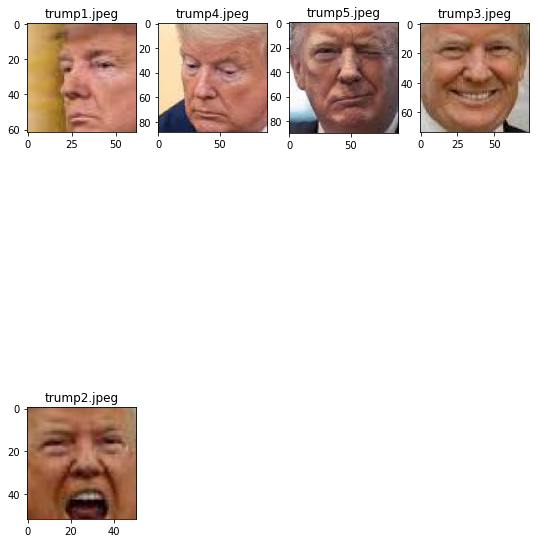

In [97]:
selection, path = show_multiple_images(face_img_path+'trump')

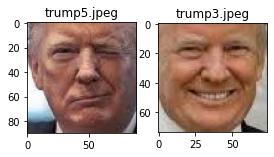

In [98]:
move_selected(selection, path)

# Model selection

In [0]:
senet_model = VGGFace(model='senet50', include_top=False, input_shape=(224, 224, 3))

In [69]:
senet_model.summary()

Model: "vggface_senet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
____________________________________________________________________________________

In [0]:
def fr_model():
  last_layer = senet_model.get_layer('avg_pool').output
  X = Flatten(name='flatten')(last_layer)
  X = Dense(128, name='dense_layer')(X)
  # L2 normalization
  out = Lambda(lambda  x: K.l2_normalize(x,axis=1))(X)

  # Create model instance
  model = Model(senet_model.input, out, name='fr_model')
  return model


In [0]:
model = fr_model()

In [72]:
model.summary()

Model: "fr_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
___________________________________________________________________________________________

###Image encoding

**Converting images into feature vectors**


In [0]:
def img_to_encoding(image_path, model):
    img = image.load_img(image_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = utils.preprocess_input(x, version=2)
    embedding = model.predict(x)
    return embedding

In [105]:
dist = {}
for f in os.listdir(selected_path):

  for r, d, fil_list in os.walk(selected_path+f):
    
    dir_list = r.split("/")
    label = dir_list[-1].strip()
    encodes = []
    for fname in fil_list:
      encoding = img_to_encoding(selected_path+label+'/'+fname, model)
      encodes.append(encoding)
    l2_dist = np.linalg.norm(encodes[0]-encodes[1])
    dist[label] = round(l2_dist, 3)

print('Eucledian Distance between the president files')    
print(dist)


Eucledian Distance between the president files
{'bush': 0.534, 'carter': 0.466, 'clinton': 0.781, 'nixon': 0.688, 'obama': 0.763, 'reagan': 0.819, 'trump': 0.528}


In [0]:
col_data = {}
all_flist = []
all_encodes = {}
for f in os.listdir(selected_path):

  for r, d, fil_list in os.walk(selected_path+f):
    for fname in fil_list:
      fname_only = fname.split('.')[0]
      all_flist.append(fname_only)
      enc = img_to_encoding(selected_path+f+'/'+fname, model)
      all_encodes[fname_only] = enc

In [108]:
print(len(all_encodes['trump3'][0]))

128


In [109]:
for fname in all_flist:
  enc_1 = all_encodes[fname]
  enc_list = []
  for key, val in all_encodes.items():
    l2_dist = np.linalg.norm(val-enc_1)
    enc_list.append(l2_dist)
  col_data[fname] = enc_list

print(col_data)

{'bush1': [0.0, 0.5338132, 1.1664678, 1.2060772, 1.2190562, 1.2676475, 1.0601052, 1.1060146, 1.1659642, 1.1582329, 1.1415838, 1.1534094, 1.1699021, 1.139787], 'bush3': [0.5338132, 0.0, 1.1179043, 1.1301317, 1.2549554, 1.2726831, 1.037172, 1.0393399, 1.1126219, 1.1312126, 1.1107327, 1.0398295, 1.0927022, 1.1029226], 'carter1': [1.1664678, 1.1179043, 0.0, 0.46648312, 1.1057931, 1.1001256, 1.1265, 1.1712083, 1.0200244, 1.076397, 1.0003319, 1.0474874, 0.8715068, 0.85732436], 'carter4': [1.2060772, 1.1301317, 0.46648312, 0.0, 1.2088802, 1.1613063, 1.2033135, 1.210851, 1.1232505, 1.1425631, 1.1033471, 1.0628777, 0.9028702, 0.8811786], 'clinton5': [1.2190562, 1.2549554, 1.1057931, 1.2088802, 0.0, 0.7814278, 1.149237, 1.1746353, 1.0813472, 1.0947526, 1.1228582, 1.1913404, 0.97642297, 1.0271643], 'clinton2': [1.2676475, 1.2726831, 1.1001256, 1.1613063, 0.7814278, 0.0, 1.2208148, 1.1608168, 1.1802785, 1.2342948, 1.1752048, 1.1874857, 1.0075775, 1.104326], 'nixon3': [1.0601052, 1.037172, 1.1265, 

### Visualization

In [110]:
import pandas as pd
df = pd.DataFrame(col_data,columns=all_flist)
row_names = {}
for i in range(0, len(df)):
  row_names[i] = all_flist[i]
renamed_df = df.rename(row_names)
renamed_df

,bush1,bush3,carter1,carter4,clinton5,clinton2,nixon3,nixon5,obama4,obama3,reagan2,reagan1,trump5,trump3
bush1,0.000000,0.533813,1.166468,1.206077,1.219056,1.267648,1.060105,1.106015,1.165964,1.158233,1.141584,1.153409,1.169902,1.139787
bush3,0.533813,0.000000,1.117904,1.130132,1.254955,1.272683,1.037172,1.039340,1.112622,1.131213,1.110733,1.039829,1.092702,1.102923
carter1,1.166468,1.117904,0.000000,0.466483,1.105793,1.100126,1.126500,1.171208,1.020024,1.076397,1.000332,1.047487,0.871507,0.857324
carter4,1.206077,1.130132,0.466483,0.000000,1.208880,1.161306,1.203313,1.210851,1.123250,1.142563,1.103347,1.062878,0.902870,0.881179
clinton5,1.219056,1.254955,1.105793,1.208880,0.000000,0.781428,1.149237,1.174635,1.081347,1.094753,1.122858,1.191340,0.976423,1.027164
clinton2,1.267648,1.272683,1.100126,1.161306,0.781428,0.000000,1.220815,1.160817,1.180279,1.234295,1.175205,1.187486,1.007578,1.104326
nixon3,1.060105,1.037172,1.126500,1.203313,1.149237,1.220815,0.000000,0.688192,1.119039,1.219653,1.064522,1.054861,1.041828,1.019094
nixon5,1.106015,1.039340,1.171208,1.210851,1.174635,1.160817,0.688192,0.000000,1.067192,1.132573,1.130777,1.053781,1.014094,1.062443
obama4,1.165964,1.112622,1.020024,1.123250,1.081347,1.180279,1.119039,1.067192,0.000000,0.762555,1.084702,1.135152,1.046029,1.139331
obama3,1.158233,1.131213,1.076397,1.142563,1.094753,1.234295,1.219653,1.132573,0.762555,0.000000,1.177771,1.104085,1.178855,1.207346


In [111]:
import seaborn as sns

color_map = sns.light_palette("green", as_cmap=True)
styled_df = renamed_df.style.background_gradient(cmap=color_map)
styled_df

,bush1,bush3,carter1,carter4,clinton5,clinton2,nixon3,nixon5,obama4,obama3,reagan2,reagan1,trump5,trump3
bush1,0.000000,0.533813,1.166468,1.206077,1.219056,1.267648,1.060105,1.106015,1.165964,1.158233,1.141584,1.153409,1.169902,1.139787
bush3,0.533813,0.000000,1.117904,1.130132,1.254955,1.272683,1.037172,1.039340,1.112622,1.131213,1.110733,1.039829,1.092702,1.102923
carter1,1.166468,1.117904,0.000000,0.466483,1.105793,1.100126,1.126500,1.171208,1.020024,1.076397,1.000332,1.047487,0.871507,0.857324
carter4,1.206077,1.130132,0.466483,0.000000,1.208880,1.161306,1.203313,1.210851,1.123250,1.142563,1.103347,1.062878,0.902870,0.881179
clinton5,1.219056,1.254955,1.105793,1.208880,0.000000,0.781428,1.149237,1.174635,1.081347,1.094753,1.122858,1.191340,0.976423,1.027164
clinton2,1.267648,1.272683,1.100126,1.161306,0.781428,0.000000,1.220815,1.160817,1.180279,1.234295,1.175205,1.187486,1.007578,1.104326
nixon3,1.060105,1.037172,1.126500,1.203313,1.149237,1.220815,0.000000,0.688192,1.119039,1.219653,1.064522,1.054861,1.041828,1.019094
nixon5,1.106015,1.039340,1.171208,1.210851,1.174635,1.160817,0.688192,0.000000,1.067192,1.132573,1.130777,1.053781,1.014094,1.062443
obama4,1.165964,1.112622,1.020024,1.123250,1.081347,1.180279,1.119039,1.067192,0.000000,0.762555,1.084702,1.135152,1.046029,1.139331
obama3,1.158233,1.131213,1.076397,1.142563,1.094753,1.234295,1.219653,1.132573,0.762555,0.000000,1.177771,1.104085,1.178855,1.207346


**From the seaborn plot, we can look at the eucledian distances between the president encoding images. This can be used to decide the cutoffs**

### Preparing 2 encoding databases

**dict 1 will be the encoding database in the club**       

**dict 2 will be encoding done from door camera**

In [0]:
# separate the encodings for each person into 2 dicts
# dict 1 will be the encoding database in the club
db_encodes = {}
# dict 2 will be encoding done from door camera
camera_encodes = {}
for key, val in all_encodes.items():
  pres_name = ''.join([i for i in key if not i.isdigit()]) 
  if not pres_name in db_encodes:
    db_encodes[pres_name] = val
  else:
    camera_encodes[pres_name] = val

In [0]:
same_dist = {}
for name in pres_list:
  enc_db = db_encodes[name]
  enc_camera = camera_encodes[name]
  l2_dist = np.linalg.norm(enc_db-enc_camera)
  same_dist[name] = l2_dist

In [0]:
#We will delete president nixon from our database and see what our facial recognition does
del db_encodes['nixon'] 

## Let's try our facial Recognition Software.
**Are you allowed in? President Nixon walks in.**

In [117]:
same_dist = {}
print('Welcome to Face Recognition')
print('Please enter the name of the person who is trying to enter the club')
g = input("Enter  the name in lower case:") 
president_entered=g
print('President ' +str(g)+ ' is trying to enter')

#current club list
#['obama', 'clinton', 'bush', 'carter', 'reagan', 'nixon', 'trump']
#deleted nixon from the existing list
pres_list=['obama', 'clinton', 'bush', 'carter', 'reagan', 'trump']
enc_camera = img_to_encoding('/content/gdrive/My Drive/Colab Notebooks/Facial Recognition/selected_images/'+str(g)+'/'+str(g)+'5.jpeg', model)
for name in pres_list:
  enc_db = db_encodes[name]
  #enc_camera = camera_encodes[name]
  l2_dist = np.linalg.norm(enc_db-enc_camera)
  same_dist[name] = l2_dist
print('\n')
print('Loading.............')
for key,val in same_dist.items():
  if val>1:
    print('..............')
    last_key=sorted(same_dist.keys())[-1]
    if key== last_key:
        print('Match not found')
  else:
    print('Match found')
    print('Welcome President ' +str(key))
    break

Welcome to Face Recognition
Please enter the name of the person who is trying to enter the club
Enter  the name in lower case:nixon
President nixon is trying to enter


Loading.............
..............
..............
..............
..............
..............
..............
Match not found


**Are you allowed in? President Clinton walks in.**

In [118]:
same_dist = {}
print('Welcome to Face Recognition')
print('Please enter the name of the person who is trying to enter the club')
g = input("Enter  the name in lower case:") 
president_entered=g
print('President ' +str(g)+ ' is trying to enter')

#current club list
#['obama', 'clinton', 'bush', 'carter', 'reagan', 'nixon', 'trump']
#deleted nixon from the existing list
pres_list=['obama', 'clinton', 'bush', 'carter', 'reagan', 'trump']
enc_camera = img_to_encoding('/content/gdrive/My Drive/Colab Notebooks/Facial Recognition/selected_images/'+str(g)+'/'+str(g)+'5.jpeg', model)
for name in pres_list:
  enc_db = db_encodes[name]
  #enc_camera = camera_encodes[name]
  l2_dist = np.linalg.norm(enc_db-enc_camera)
  same_dist[name] = l2_dist
print('\n')
print('Loading.............')
for key,val in same_dist.items():
  if val>1:
    print('..............')
    last_key=sorted(same_dist.keys())[-1]
    if key== last_key:
        print('Match not found')
  else:
    print('Match found')
    print('Welcome President ' +str(key))
    break

Welcome to Face Recognition
Please enter the name of the person who is trying to enter the club
Enter  the name in lower case:clinton
President clinton is trying to enter


Loading.............
..............
Match found
Welcome President clinton
